## Load Dataset

In [21]:
import pandas as pd
import numpy as np
df = pd.read_csv('train.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2,-56,-0.33,-0.09,0.90,0.2,-11,12,0.004,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.032,-0.0009
1,470,-39,0.02,0.12,0.39,-0.6,-12,8,0.009,-1.6,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.034,-0.0011
2,165,4,0.14,0.14,0.78,0.4,-11,-9,-0.003,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,1.0,0.034,-0.0012
3,-113,5,-0.12,0.11,1.06,0.6,-10,-7,-0.008,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.9,0.033,-0.0011
4,-411,-21,-0.17,0.07,1.33,-0.6,-11,0,0.002,0.1,...,0.0,0.0,0.0,0.0,0.0,-0.002,0.0,0.9,0.032,-0.0008


## Dataset Info

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7154 entries, 0 to 7153
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7154 non-null   int64  
 1   1       7154 non-null   int64  
 2   2       7154 non-null   float64
 3   3       7154 non-null   float64
 4   4       7154 non-null   float64
 5   5       7154 non-null   float64
 6   6       7154 non-null   int64  
 7   7       7154 non-null   int64  
 8   8       7154 non-null   float64
 9   9       7154 non-null   float64
 10  10      7154 non-null   float64
 11  11      7154 non-null   float64
 12  12      7154 non-null   float64
 13  13      7154 non-null   float64
 14  14      7154 non-null   float64
 15  15      7154 non-null   float64
 16  16      7154 non-null   float64
 17  17      7154 non-null   float64
 18  18      7154 non-null   float64
 19  19      7154 non-null   float64
 20  20      7154 non-null   float64
 21  21      7154 non-null   float64
 22  

## Data process

In [23]:
array = np.array(df)
n = array.shape[0]
np.random.seed(2)
train_index = set(np.random.choice(n, int(n/4*3), replace=False))
test_index = set(range(n)) - train_index
(train, test) = (array[np.array(list(train_index)), :],
                 array[np.array(list(test_index)), :])
(X_train, y_train) = (train[:, :-1], train[:, -1])
(X_test, y_test) = (test[:, :-1], test[:, -1])

# model

In [31]:
from collections import deque


class Regression_Tree:

    class Node:
        def __init__(self, aggregation, weight, depth):
            self.left = None
            self.right = None
            self.feature = None
            self.value = None
            self.aggregation = aggregation
            self.weight = weight
            self.depth = depth

    def __init__(self, Lambda=1.0, Gamma=0.0, plot=True):
        self.root = None
        self.Lambda = Lambda
        self.Gamma = Gamma
        self.plot = plot

    def grad(self, y, y_last):
        self.g = - 2 * (y - y_last)
        self.h = 2 * np.ones(y.shape)

    def obj(self, G, H):
        return -0.5 * (G ** 2) / (H + self.Lambda) + self.Gamma

    def weight(self, aggregation):
        return - np.sum(self.g[aggregation]) / (np.sum(self.h[aggregation]) + self.Lambda)

    def fit(self, X, y, y_last=0, max_depth=None, min_samples_split=None):
        self.grad(y, y_last)
        root_aggregation = list(range(X.shape[0]))
        self.root = self.Node(
            root_aggregation, self.weight(root_aggregation), 0)
        node_stack = deque([self.root])
        score = []
        while len(node_stack) > 0:
            cur_node = node_stack.popleft()
            if max_depth is not None and cur_node.depth >= max_depth:
                continue
            if min_samples_split is not None and len(cur_node.aggregation) < min_samples_split:
                continue
            score.append(self.MSE(X, y))
            Gsum = np.sum(self.g[cur_node.aggregation])
            Hsum = np.sum(self.h[cur_node.aggregation])
            Obj1 = self.obj(Gsum, Hsum)
            Obj2_min = np.inf
            feature_min = None
            pos_min = None
            for i in range(X.shape[1]):
                Gl = 0
                Hl = 0
                sorted_list = sorted(cur_node.aggregation,
                                     key=lambda x: X[x, i])
                j = 0
                while j < len(sorted_list):
                    cur_value = X[sorted_list[j], i]
                    while j < len(sorted_list) and X[sorted_list[j], i] == cur_value:
                        Gl += self.g[sorted_list[j]]
                        Hl += self.h[sorted_list[j]]
                        j += 1
                    Obj2 = self.obj(Gl, Hl) + self.obj(Gsum - Gl, Hsum - Hl)
                    if Obj2 < Obj2_min:
                        Obj2_min = Obj2
                        feature_min = i
                        pos_min = j
            if Obj1 - Obj2_min > 0 and pos_min != len(cur_node.aggregation):
                sorted_list = sorted(cur_node.aggregation,
                                     key=lambda x: X[x, feature_min])
                aggregationl = sorted_list[:pos_min]
                aggregationr = sorted_list[pos_min+1:]
                cur_node.left = self.Node(
                    aggregationl, self.weight(aggregationl), cur_node.depth + 1)
                cur_node.right = self.Node(
                    aggregationr, self.weight(aggregationr), cur_node.depth + 1)
                cur_node.feature = feature_min
                cur_node.value = X[sorted_list[pos_min-1], feature_min]
                node_stack.append(cur_node.left)
                node_stack.append(cur_node.right)
        if self.plot:
            from matplotlib import pyplot as plt
            plt.title('MSE curve of training')
            plt.xlabel('iteration')
            plt.ylabel('MSE')
            plt.plot(np.arange(1, len(score) + 1), np.array(score).flatten())
            plt.show()

    def predict(self, X):
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            cur_node = self.root
            while cur_node.left is not None:
                if X[i, cur_node.feature] <= cur_node.value:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right
            result[i] = cur_node.weight
        return result

    def MSE(self, X, y):
        return np.sum((self.predict(X) - y) ** 2) / X.shape[0]

    def R2(self, X, y):
        return 1 - self.MSE(X, y) / np.var(y)

    def RMSE(self, X, y):
        return self.MSE(X, y) ** 0.5


In [32]:
class XGBoost:

    def __init__(self, alpha = 0.1, plot=True):
        self.forest = []
        self.alpha = alpha
        self.plot = plot

    def fit(self, X, y, X_test = None, y_test = None, M = 50, max_depth = 5):
        score = []
        if X_test is not None and y_test is not None:
            score_test = []
        cur_y = np.zeros(y.shape)
        for i in range(M):
            tree = Regression_Tree(plot=False)
            tree.fit(X, y, cur_y, max_depth=max_depth)
            self.forest.append(tree)
            cur_y += tree.predict(X) * self.alpha
            score.append(self.MSE(X, y))
            if X_test is not None and y_test is not None:
                score_test.append(self.MSE(X_test, y_test))
        if self.plot:
            from matplotlib import pyplot as plt
            plt.title('MSE curve of training')
            plt.xlabel('iteration')
            plt.ylabel('MSE')
            plt.plot(np.arange(1, len(score) + 1), np.array(score).flatten(), label='train')
            if X_test is not None and y_test is not None:
                plt.plot(np.arange(1, len(score_test) + 1), np.array(score_test).flatten(), label='test')
            plt.legend()
            plt.show()

    def predict(self, X):
        result = 0
        for tree in self.forest:
            result += tree.predict(X) * self.alpha
        return result

    def MSE(self, X, y):
        return np.sum((self.predict(X) - y) ** 2) / X.shape[0]

    def R2(self, X, y):
        return 1 - self.MSE(X, y) / np.var(y)

    def RMSE(self, X, y):
        return self.MSE(X, y) ** 0.5


## Train

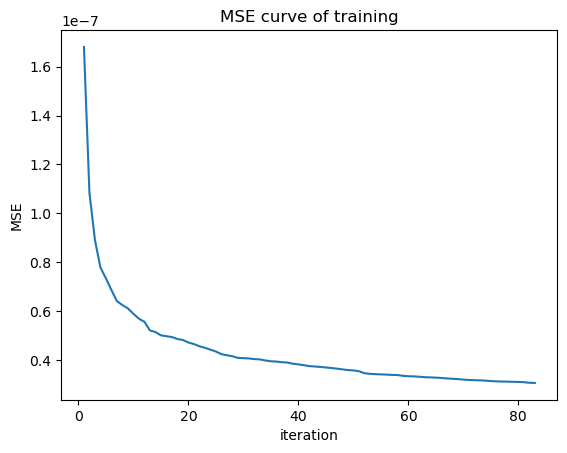

RMSE:1.9352e-04
R2:0.7862


In [33]:
model = Regression_Tree(Lambda=0.1)
model.fit(X_train, y_train, max_depth=7, min_samples_split=50)
print("RMSE:{:.4e}".format(model.RMSE(X_test, y_test)))
print("R2:{:.4f}".format(model.R2(X_test, y_test)))

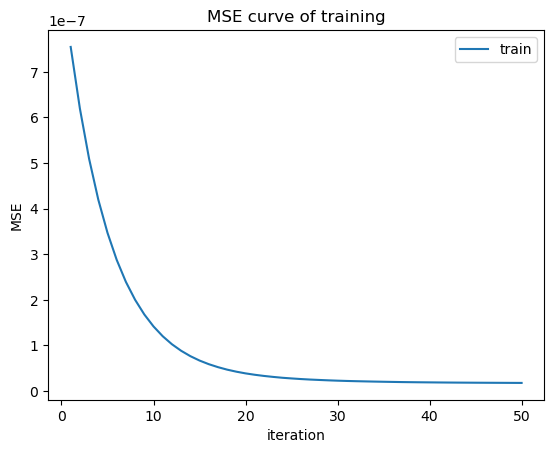

RMSE:1.6317e-04
R2:0.8480


In [34]:
model = XGBoost(alpha=0.1)
model.fit(X_train, y_train, max_depth = 5)
print("RMSE:{:.4e}".format(model.RMSE(X_test, y_test)))
print("R2:{:.4f}".format(model.R2(X_test, y_test)))

## Reference

In [35]:
from sklearn.tree import DecisionTreeRegressor  # 回归树
dtg = DecisionTreeRegressor(random_state=0)
dtg.fit(X_train, y_train)
print("RMSE:{:.4e}".format(np.mean((dtg.predict(X_test) - y_test) ** 2) ** 0.5))
print("R2:{:.4f}".format(dtg.score(X_test, y_test)))

RMSE:2.4090e-04
R2:0.6687


In [36]:
from sklearn.ensemble import GradientBoostingRegressor  # GBDT
gbdt = GradientBoostingRegressor(random_state=0)
gbdt.fit(X_train, y_train)
print("RMSE:{:.4e}".format(np.mean((gbdt.predict(X_test) - y_test) ** 2) ** 0.5))
print("R2:{:.4f}".format(gbdt.score(X_test, y_test)))

RMSE:1.6317e-04
R2:0.8480
